In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate

In [2]:
os.environ["PATH"]='/home/manhducnmd/latex/bin/x86_64-linux'
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.family'] = 'sans-serif'

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-26 13:09:26.157671: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-26 13:09:26.734834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:5e:00.0
2024-07-26 13:09:26.735146: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-26 13:09:26.737183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-26 13:09:26.738726: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-26 13:09:26.739039: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-26 13:09:26.740834: I tensorflow/stream_executor

In [4]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [5]:
bkg_sr_jet_1 = np.load('background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('dd10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('dd10_sr_25_jet_2.npy')




In [6]:
print(np.shape(bkg_sr_jet_1), np.shape(signal_sr_jet_1))

(65859, 25, 25) (197943, 25, 25)


In [8]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [9]:
class ConvScaleShift(keras.layers.Layer):
    def __init__(self, channels, filters, kernel_size, trable = False, conv_trable = False, **kwargs):
        super(ConvScaleShift, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', trainable=conv_trable)

        self.shift = self.add_weight(name='shift', shape=(filters), 
                                     initializer='zeros', trainable=True)
        self.scale = self.add_weight(name='scale', shape=(1, 1, channels, filters), 
                                     initializer='ones', trainable=True)
        self.trable = trable
        self.act = keras.activations.relu
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift': self.shift,
            'scale': self.scale,
            'trable': self.trable,
            'act': self.act,
        })
        return config
    # Defines the computation
    def call(self, inputs):
        if self.trable == False:
            x = self.conv(inputs)
            x = self.act(x)
            return x
        else:
            y = self.conv(inputs)
            oldw = self.non_trainable_weights[0]
            oldb = self.non_trainable_weights[1]
            neww = tf.multiply(oldw, self.scale) 
            newb = tf.add(oldb, self.shift)
            x = tf.nn.conv2d(inputs, neww, strides = 1, padding='SAME') + newb            
            x = self.act(x)
            return x

In [10]:
#Defining the CWoLA model
def CWoLA(p_i, trable = False, conv_trable = False):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        ConvScaleShift(1 , 64, (5,5), trable = trable, conv_trable = conv_trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 128, (3,3), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        ConvScaleShift(128, 128, (3,3), trable = trable, conv_trable = conv_trable),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [14]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

In [16]:
epsilon_s_full = []
for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
    epsilon_s_1 = []
    for i in range(10):
        print(n_train_sr_signal, i)
        loaded_model = CWoLA(25, trable = True)
        loaded_model.load_weights(
            f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_ft_dd10_{n_train_sr_signal}_25')
        x_predict = loaded_model.predict([x_test_1, x_test_2])
        fpr, tpr, th = roc_curve(y_test, x_predict)
        f = interpolate.interp1d(fpr, tpr)
        epsilon_s = f([0.001, 0.01, 0.1])
        epsilon_s_1.append(epsilon_s)
    epsilon_s_full.append(epsilon_s_1)
epsilon_s_full = np.array(epsilon_s_full)


        

50 0


2024-07-26 13:11:42.408713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-26 13:11:42.553827: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-26 13:11:43.111041: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


50 1
50 2
50 3


50 4
50 5
50 6


50 7
50 8
50 9
100 0


100 1
100 2
100 3
100 4


100 5
100 6
100 7
100 8


100 9
150 0
150 1
150 2
150 3
150 4


150 5
150 6
150 7
150 8
150 9


200 0
200 1
200 2
200 3
200 4
200 5
200 6


200 7
200 8
200 9
250 0
250 1
250 2
250 3
250 4


250 5
250 6
250 7
250 8
250 9
300 0
300 1
300 2


300 3
300 4
300 5
300 6
300 7
300 8
300 9
350 0
350 1


350 2
350 3
350 4
350 5
350 6
350 7
350 8
350 9
400 0
400 1
400 2


400 3
400 4
400 5
400 6
400 7
400 8
400 9
450 0
450 1
450 2
450 3


450 4
450 5
450 6
450 7
450 8
450 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6


500 7
500 8
500 9
600 0
600 1
600 2
600 3
600 4
600 5
600 6
600 7
600 8
600 9
700 0


700 1
700 2
700 3
700 4
700 5
700 6
700 7
700 8
700 9
800 0
800 1
800 2
800 3
800 4
800 5


800 6
800 7
800 8
800 9
900 0
900 1
900 2
900 3
900 4
900 5
900 6
900 7
900 8
900 9
1000 0
1000 1
1000 2


1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
1100 0
1100 1
1100 2
1100 3
1100 4
1100 5
1100 6
1100 7
1100 8
1100 9
1200 0


1200 1
1200 2
1200 3
1200 4
1200 5
1200 6
1200 7
1200 8
1200 9


In [17]:
mean_results = np.mean(epsilon_s_full, axis = 1)
std_results = np.std(epsilon_s_full, axis = 1)

In [ ]:
epsilon_s_full_2 = []
for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
    epsilon_s_1_2 = []
    for i in range(10):
        print(n_train_sr_signal, i)
        #loaded_model_2 = CWoLA(50, trable = True)
        #loaded_model_2.load_weights(
            #f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_ht_dd10_{n_train_sr_signal}_50')
        loaded_model_2 = keras.models.load_model(
            f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_dd10_{n_train_sr_signal}_25.keras')
        x_predict_2 = loaded_model_2.predict([x_test_1, x_test_2])
        fpr_2, tpr_2, th_2 = roc_curve(y_test, x_predict_2)
        f_2 = interpolate.interp1d(fpr_2, tpr_2)
        epsilon_s_2 = f_2([0.001, 0.01, 0.1])
        epsilon_s_1_2.append(epsilon_s_2)
    epsilon_s_full_2.append(epsilon_s_1_2)
epsilon_s_full_2 = np.array(epsilon_s_full_2)


        

50 0
50 1
50 2


50 3
50 4
50 5
50 6
50 7
50 8
50 9
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
150 0
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
250 0
250 1
250 2
250 3
250 4
250 5
250 6
250 7
250 8
250 9
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
350 0
350 1
350 2
350 3
350 4
350 5
350 6
350 7
350 8
350 9
400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
450 0
450 1
450 2
450 3
450 4
450 5
450 6
450 7
450 8
450 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
600 0
600 1
600 2
600 3
600 4
600 5
600 6
600 7
600 8
600 9
700 0
700 1
700 2
700 3
700 4
700 5
700 6
700 7
700 8
700 9
800 0
800 1
800 2
800 3
800 4
800 5
800 6
800 7
800 8
800 9
900 0
900 1
900 2
900 3
900 4
900 5
900 6
900 7
900 8
900 9
1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8


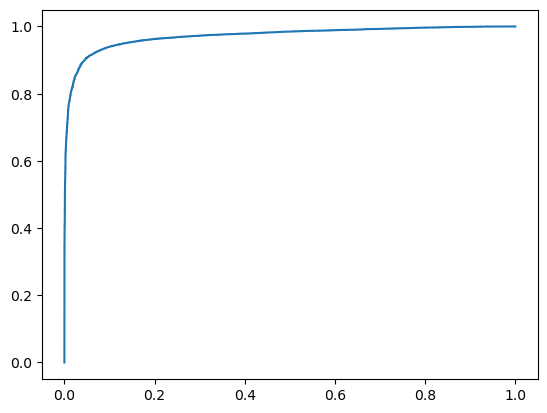

In [117]:
plt.plot(fpr_2, tpr_2)

In [ ]:
mean_results_2 = np.mean(epsilon_s_full_2, axis = 1)
std_results_2 = np.std(epsilon_s_full_2, axis = 1)

In [ ]:
print(np.shape(mean_results))

In [ ]:
print(np.shape(mean_results_2))

In [ ]:
print(mean_results)

In [ ]:
print(mean_results_2)

In [ ]:
from uncertainties import unumpy
array = unumpy.uarray(mean_results, std_results)
print(array)

In [ ]:
array_2 = unumpy.uarray(mean_results_2, std_results_2)
print(array_2)

In [ ]:
x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200])
sig_before = np.sqrt(2*((x+25000)*np.log(x/25000 + 1) - x))
                     
sig_after_1 = unumpy.sqrt(2*((x*array[:,0]+25000*0.001)*unumpy.log(x*array[:, 0]/(25000*0.001) + 1)
                         -x*array[:,0]))
sig_after_2 = unumpy.sqrt(2*((x*array[:,1]+25000*0.01)*unumpy.log(x*array[:, 1]/(25000*0.01) + 1)
                         -x*array[:,1]))
sig_after_3 = unumpy.sqrt(2*((x*array[:,2]+25000*0.1)*unumpy.log(x*array[:, 2]/(25000*0.1) + 1)
                         -x*array[:,2]))


                     
                    
                      
                      

In [ ]:
sig_after_1_std = []
sig_after_2_std = []
sig_after_3_std = []
sig_after_1_mean = []
sig_after_2_mean = []
sig_after_3_mean = []
sig_after_1_mean.append(0)
sig_after_2_mean.append(0)
sig_after_3_mean.append(0)
sig_after_1_std.append(0)
sig_after_2_std.append(0)
sig_after_3_std.append(0)

sig_before = np.append(0, sig_before)

for w, y, z in zip(sig_after_1, sig_after_2, sig_after_3):
    sig_after_1_mean.append(w.n)
    sig_after_1_std.append(w.s)
    
    sig_after_2_mean.append(y.n)
    sig_after_2_std.append(y.s)
    
    sig_after_3_mean.append(z.n)
    sig_after_3_std.append(z.s)
    

    
    

In [ ]:
sig_after_1_2 = unumpy.sqrt(2*((x*array_2[:,0]+25000*0.001)*unumpy.log(x*array_2[:, 0]/(25000*0.001) + 1)
                         -x*array_2[:,0]))
sig_after_2_2 = unumpy.sqrt(2*((x*array_2[:,1]+25000*0.01)*unumpy.log(x*array_2[:, 1]/(25000*0.01) + 1)
                         -x*array_2[:,1]))
sig_after_3_2 = unumpy.sqrt(2*((x*array_2[:,2]+25000*0.1)*unumpy.log(x*array_2[:, 2]/(25000*0.1) + 1)
                         -x*array_2[:,2]))


                     
                    
                      
                      

In [ ]:
sig_after_1_std_2 = []
sig_after_2_std_2 = []
sig_after_3_std_2 = []
sig_after_1_mean_2 = []
sig_after_2_mean_2 = []
sig_after_3_mean_2 = []
sig_after_1_mean_2.append(0)
sig_after_2_mean_2.append(0)
sig_after_3_mean_2.append(0)
sig_after_1_std_2.append(0)
sig_after_2_std_2.append(0)
sig_after_3_std_2.append(0)


for w, y, z in zip(sig_after_1_2, sig_after_2_2, sig_after_3_2):
    sig_after_1_mean_2.append(w.n)
    sig_after_1_std_2.append(w.s)
    
    sig_after_2_mean_2.append(y.n)
    sig_after_2_std_2.append(y.s)
    
    sig_after_3_mean_2.append(z.n)
    sig_after_3_std_2.append(z.s)
    

    
    

25x25 res

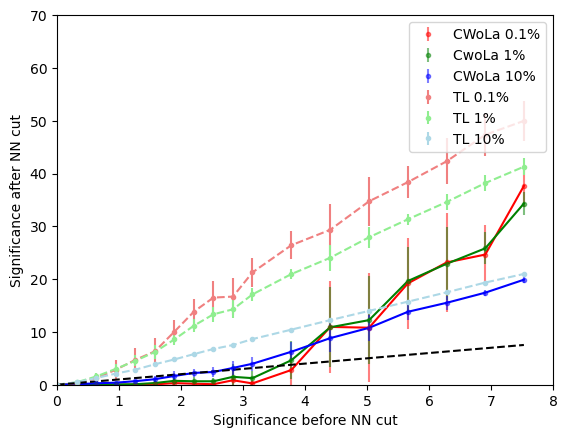

In [29]:
plt.figure(figsize=(7, 8))
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, 
             fmt = '.', c='r', label = 'CWoLa-$\epsilon_b = 0.1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, 
             fmt = '.', c = 'g', label = 'CwoLa-$\epsilon_b = 1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, 
             fmt = '.', c = 'b', label = 'CWoLa-$\epsilon_b = 10$%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, 
             fmt = '.', c='lightcoral', label = 'TL-$\epsilon_b = 0.1$%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, 
             fmt = '.', c = 'lightgreen', label = 'TL-$\epsilon_b = 1$%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, 
             fmt = '.', c = 'lightblue', label = 'TL-$\epsilon_b = 10$%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')

plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.text(4, 70, "DD for 25x25 res.")
plt.xlim(0, 8.1)
plt.ylim(0, 72)
plt.show()

50x50 res

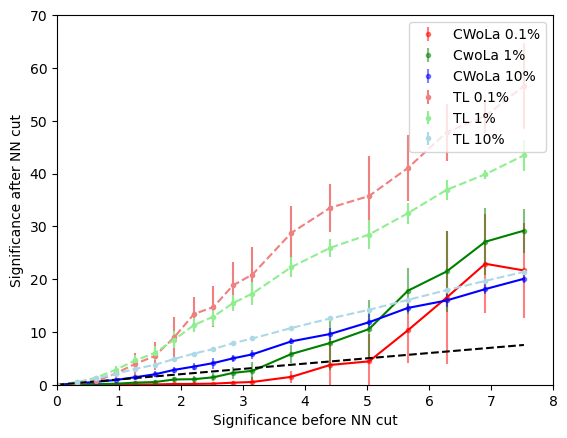

In [27]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'CWoLa $0.1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'CwoLa $1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'CWoLa $10$%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'TL $0.1$%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'TL $1$%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'TL $10$%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

75x75 res

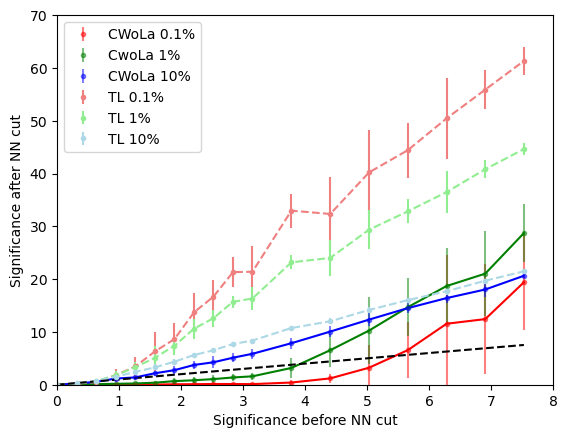

In [27]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'CWoLa $0.1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'CwoLa 1%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'CWoLa 10%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'TL $0.1$%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'TL $1$%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'TL $10$%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

Meta transfer learning

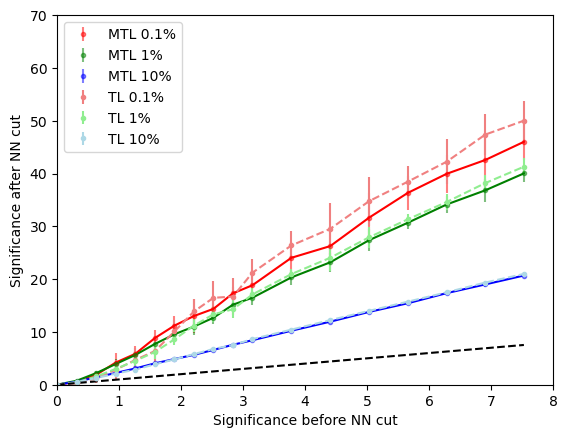

In [90]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'MTL 0.1%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'MTL 1%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'MTL 10%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'TL 0.1%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'TL 1%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'TL 10%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

50x50 res

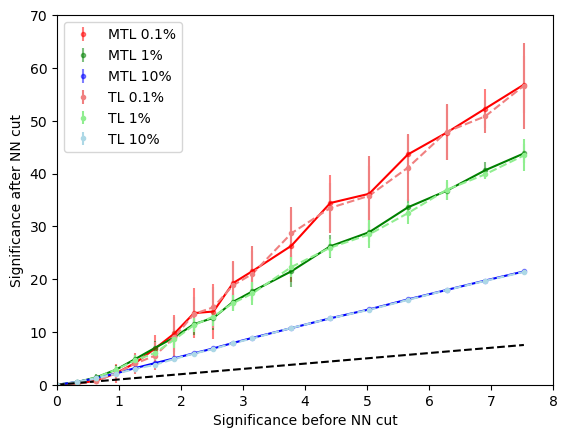

In [72]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'MTL $0.1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'MTL $1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'MTL $10$%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'TL $0.1$%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'TL $1$%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'TL $10$%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

Hard task vs none 25x25

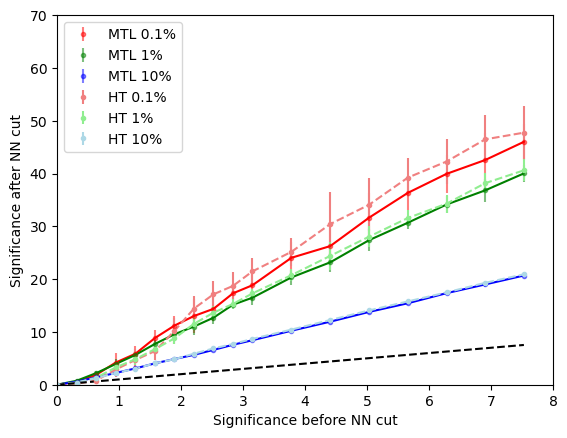

In [115]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'MTL $0.1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'MTL $1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'MTL $10$%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'HT $0.1$%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'HT $1$%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'HT $10$%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

50x50

In [ ]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'MTL 0.1%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'MTL 1%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'MTL 10%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'HT 0.1%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'HT 1%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'HT 10%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

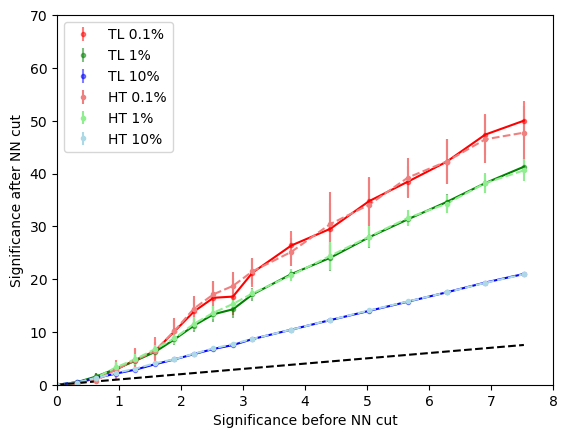

In [128]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'TL 0.1%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'TL 1%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'TL 10%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'HT 0.1%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'HT 1%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'HT 10%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

In [133]:
print(sig_after_1_mean)
print(sig_after_1_mean_2)

[0, 0.29805328884086496, 1.2307793226847288, 2.849855939779427, 4.692389469327477, 6.378709443870646, 10.092420156578992, 13.86965733802547, 16.4632410394271, 16.692972125628454, 21.217590899766098, 26.3751404673273, 29.524258741835393, 34.76379421723542, 38.45909355455159, 42.22893199631615, 47.372787437190894, 50.00865278475393]
[0, 0.21595103645226196, 0.7920533941842527, 2.887617557451105, 4.691611149339081, 6.367634925804574, 10.192644829894812, 14.422228123679398, 17.125585738353244, 18.715280626253985, 21.46888739450683, 25.16775516943062, 30.42496661261538, 34.085677374194304, 39.22566288993811, 42.275313642918846, 46.47662725319519, 47.73836032131675]


In [91]:
print(sig_after_1_mean)
print(sig_after_1_mean_2)

[0, 0.5391936829214466, 1.8814741594187798, 4.20629386900737, 5.855390525861374, 8.842028456721597, 11.194343072600146, 13.013352705066131, 14.369177660109859, 17.310230489444727, 18.84107945984573, 24.03941303119999, 26.255753185775827, 31.63882249140575, 36.338348907571266, 39.93903100432255, 42.56525143330692, 46.001262519299274]
[0, 0.29805328884086496, 1.2307793226847288, 2.849855939779427, 4.692389469327477, 6.378709443870646, 10.092420156578992, 13.86965733802547, 16.4632410394271, 16.692972125628454, 21.217590899766098, 26.3751404673273, 29.524258741835393, 34.76379421723542, 38.45909355455159, 42.22893199631615, 47.372787437190894, 50.00865278475393]


In [63]:
loaded_model = keras.models.load_model('ft_run_9_id10_1000_25.keras')
x_predict = loaded_model.predict([x_test_1, x_test_2])


In [64]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


In [65]:
fpr, tpr, th = roc_curve(y_test, x_predict)

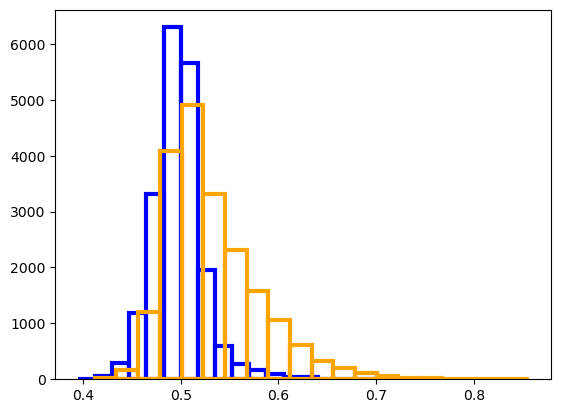

In [66]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()


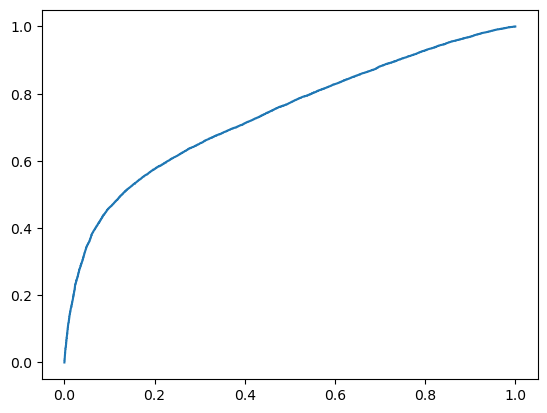

0.7374694162499998


In [67]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test, x_predict))

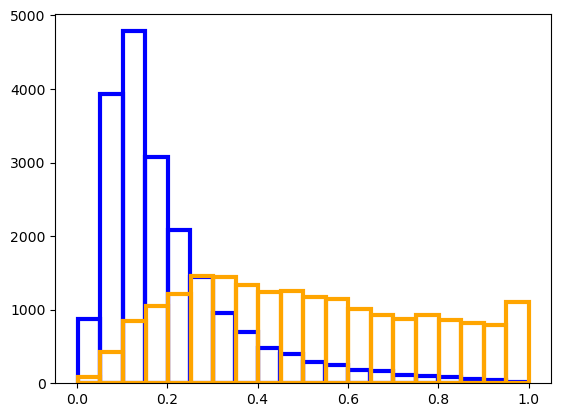

In [55]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()


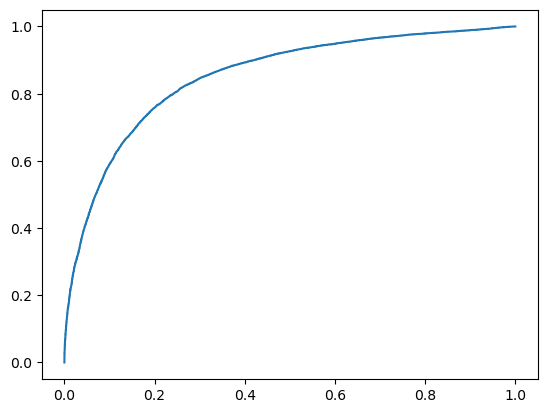

0.8516413599999999


In [62]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test, x_predict))